# Machine Learning with Spark

In this lesson we'll take a look at how to implement and evaluate machine learning models with spark.

## Setup

First we'll do a couple of imports and setup our spark session.

In [1]:
%matplotlib inline
from pydataset import data

import pyspark
import pyspark.ml
from pyspark.sql.functions import *

spark = pyspark.sql.SparkSession.builder.getOrCreate()

The data we'll use for this lesson is the `swiss` dataset. We'll cleanup the column names just a bit before we turn the dataset into a spark dataframe.

In [3]:
swiss = data("swiss")
swiss.columns = [col.lower().replace(".", "_") for col in swiss]
swiss = spark.createDataFrame(swiss)
swiss.show(5)

+---------+-----------+-----------+---------+--------+----------------+
|fertility|agriculture|examination|education|catholic|infant_mortality|
+---------+-----------+-----------+---------+--------+----------------+
|     80.2|       17.0|         15|       12|    9.96|            22.2|
|     83.1|       45.1|          6|        9|   84.84|            22.2|
|     92.5|       39.7|          5|        5|    93.4|            20.2|
|     85.8|       36.5|         12|        7|   33.77|            20.3|
|     76.9|       43.5|         17|       15|    5.16|            20.6|
+---------+-----------+-----------+---------+--------+----------------+
only showing top 5 rows



## Classification

We'll first take a look at implementing a classification model. In order to do so, we'll need a categorical variable to predict. We'll transform the `catholic` column into a categorical variable indicating whether a province is catholic or not. 

First we'll plot a histogram to justify why this transformation is reasonable to make:

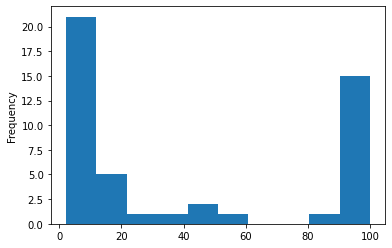

In [4]:
swiss.toPandas().catholic.plot.hist()